In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train=pd.read_csv('../input/sejong-ai-challenge-p1/train.csv')
test=pd.read_csv('../input/sejong-ai-challenge-p1/test.csv')
submit=pd.read_csv('../input/sejong-ai-challenge-p1/sample_submission.csv')

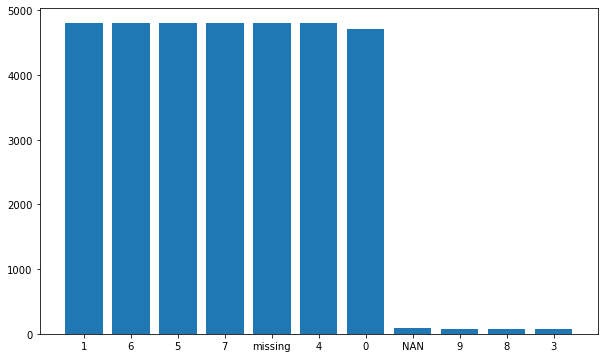

In [3]:
# 데이터 불균형
# 이상 label 발견. label의 object화. 즉, 숫자로 바꿔준다. 

temp=train['label'].value_counts()

fig,ax=plt.subplots(1,1,figsize=(10,6))

ax.bar(temp.index,temp)

plt.show()

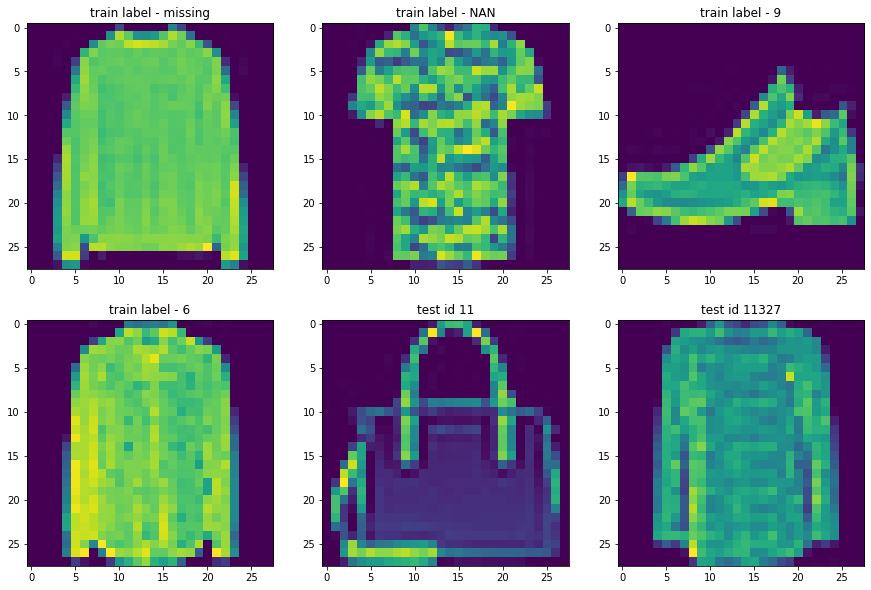

In [4]:
# 처음 데이터에서 to_numpy함수때문인지 PIL 라이브러리인지 잘못사용하여 object형태로 됐다. 
# 숫자로 다시 표시

fig,ax=plt.subplots(2,3,figsize=(15,10))

ax[0,0].imshow(train.iloc[33838][1:-1].values.astype(int).reshape(28,28))
ax[0,0].set_title('train label - missing')

ax[0,1].imshow(train.iloc[3][1:-1].values.astype(int).reshape(28,28))
ax[0,1].set_title('train label - NAN')

ax[0,2].imshow(train.iloc[1][1:-1].values.astype(int).reshape(28,28))
ax[0,2].set_title('train label - 9')

ax[1,0].imshow(train.iloc[2][1:-1].values.astype(int).reshape(28,28))
ax[1,0].set_title('train label - 6')

ax[1,1].imshow(test.iloc[0][1:].values.astype(int).reshape(28,28))
ax[1,1].set_title('test id 11')

ax[1,2].imshow(test.iloc[1613][1:].values.astype(int).reshape(28,28))
ax[1,2].set_title('test id 11327')

plt.show()

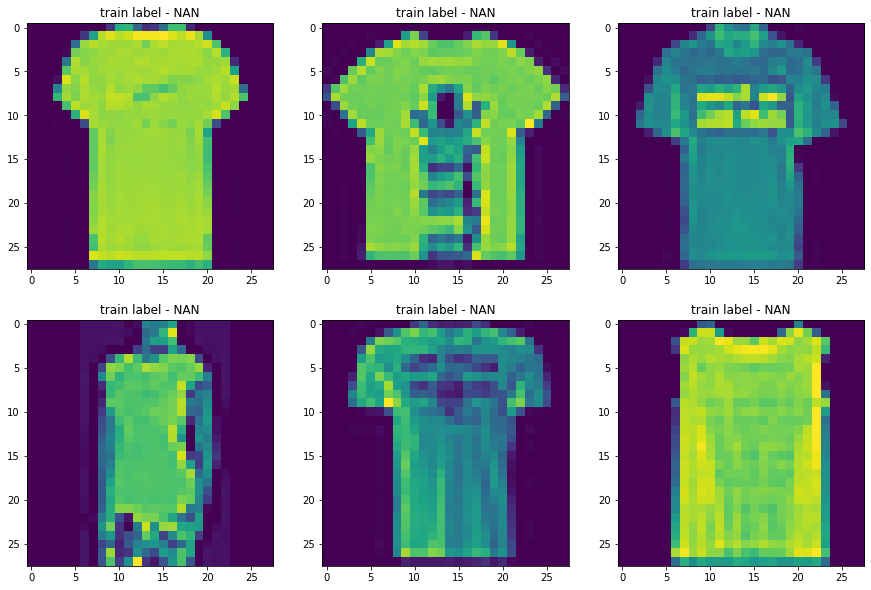

In [5]:
# train[train['label']=='NAN']

fig,ax=plt.subplots(2,3,figsize=(15,10))

ax[0,0].imshow(train.iloc[10][1:-1].values.astype(int).reshape(28,28))
ax[0,0].set_title('train label - NAN')

ax[0,1].imshow(train.iloc[12][1:-1].values.astype(int).reshape(28,28))
ax[0,1].set_title('train label - NAN')

ax[0,2].imshow(train.iloc[34][1:-1].values.astype(int).reshape(28,28))
ax[0,2].set_title('train label - NAN')

ax[1,0].imshow(train.iloc[66][1:-1].values.astype(int).reshape(28,28))
ax[1,0].set_title('train label - NAN')

ax[1,1].imshow(train.iloc[724][1:-1].values.astype(int).reshape(28,28))
ax[1,1].set_title('train label - NAN')

ax[1,2].imshow(train.iloc[730][1:-1].values.astype(int).reshape(28,28))
ax[1,2].set_title('train label - NAN')

plt.show()

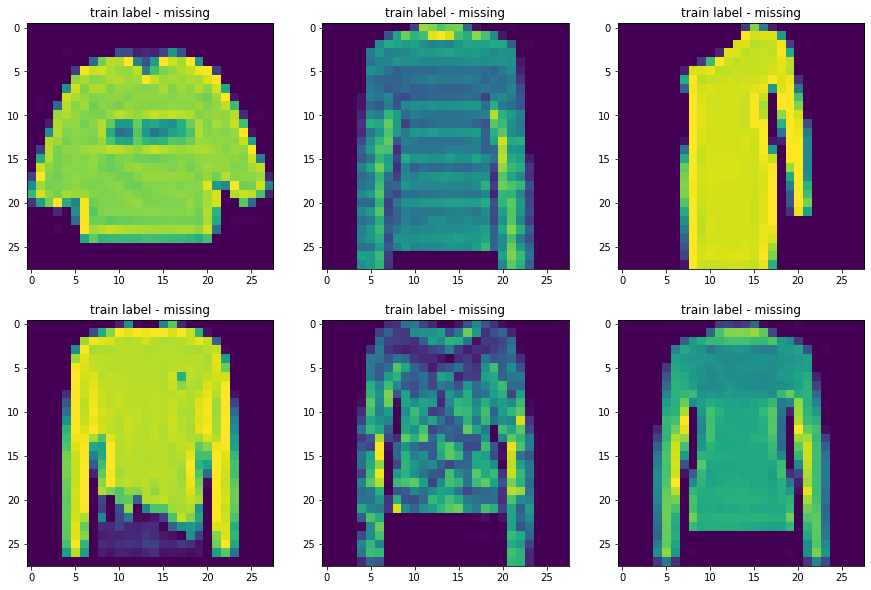

In [6]:
# train[train['label']=='missing']

fig,ax=plt.subplots(2,3,figsize=(15,10))

ax[0,0].imshow(train.iloc[0][1:-1].values.astype(int).reshape(28,28))
ax[0,0].set_title('train label - missing')

ax[0,1].imshow(train.iloc[13][1:-1].values.astype(int).reshape(28,28))
ax[0,1].set_title('train label - missing')

ax[0,2].imshow(train.iloc[27][1:-1].values.astype(int).reshape(28,28))
ax[0,2].set_title('train label - missing')

ax[1,0].imshow(train.iloc[30][1:-1].values.astype(int).reshape(28,28))
ax[1,0].set_title('train label - missing')

ax[1,1].imshow(train.iloc[39][1:-1].values.astype(int).reshape(28,28))
ax[1,1].set_title('train label - missing')

ax[1,2].imshow(train.iloc[33802][1:-1].values.astype(int).reshape(28,28))
ax[1,2].set_title('train label - missing')

plt.show()

의미가 없다. missing과 nan은 몇몇개 섞여있어서 그 자체로 인정해준다. 

label 처리

In [7]:
train['label']=train['label'].apply(lambda x:'2' if x=='missing' else x)
train['label']=train['label'].apply(lambda x:'10' if x=='NAN' else x)

In [8]:
y=train['label'].astype(int).values
X=train.drop(['id','label'],axis=1).values

In [9]:
X_test=test.drop('id',axis=1).values

In [10]:
from sklearn.model_selection import train_test_split

X_tr,X_val,y_tr,y_val=train_test_split(X,y,random_state=71,stratify=y,test_size=0.2)

In [11]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader,TensorDataset

In [12]:
trainDataset=TensorDataset(torch.from_numpy(X_tr).float(),torch.from_numpy(y_tr).long())
validDataset=TensorDataset(torch.from_numpy(X_val).float(),torch.from_numpy(y_val).long())

In [13]:
trainLoader=DataLoader(dataset=trainDataset,batch_size=64,shuffle=True)
validLoader=DataLoader(dataset=validDataset,batch_size=64,shuffle=True)

In [14]:
!pip install torchinfo

In [15]:
# 반도체 resnet

class ResNet(nn.Module):
    def __init__(self,start_units,classes):
        super(ResNet, self).__init__()
        
        self.ln = nn.LayerNorm(10000)
        self.ln1 = nn.LayerNorm(7000)
        self.ln2 = nn.LayerNorm(4000)
        self.ln3 = nn.LayerNorm(2000)
        
        self.upblock1 = nn.Sequential(nn.Linear(start_units, 2000),nn.GELU(),nn.BatchNorm1d(2000))
        self.upblock2 = nn.Sequential(nn.Linear(2000,4000),nn.GELU(),nn.BatchNorm1d(4000))
        self.upblock3 = nn.Sequential(nn.Linear(4000,7000),nn.GELU(),nn.BatchNorm1d(7000))
        self.upblock4 = nn.Sequential(nn.Linear(7000,10000),nn.GELU(),nn.BatchNorm1d(10000))

        self.downblock1 = nn.Sequential(nn.Linear(10000, 7000),nn.GELU(),nn.BatchNorm1d(7000))
        self.downblock2 = nn.Sequential(nn.Linear(7000, 4000),nn.GELU(),nn.BatchNorm1d(4000))
        self.downblock3 = nn.Sequential(nn.Linear(4000, 2000),nn.GELU(),nn.BatchNorm1d(2000))
        self.downblock4 = nn.Sequential(nn.Linear(2000, 300),nn.GELU(),nn.BatchNorm1d(300))
        
        self.fclayer = nn.Sequential(nn.Linear(300,classes))
        
    def forward(self, x):
        upblock1_out = self.upblock1(x)
        upblock2_out = self.upblock2(upblock1_out)
        upblock3_out = self.upblock3(upblock2_out)
        upblock4_out = self.upblock4(upblock3_out)
        
        downblock1_out = self.downblock1(self.ln(upblock4_out))
        skipblock1 = downblock1_out + upblock3_out
        downblock2_out = self.downblock2(self.ln1(skipblock1))
        skipblock2 = downblock2_out + upblock2_out
        downblock3_out = self.downblock3(self.ln2(skipblock2))
        skipblock3 = downblock3_out + upblock1_out
        downblock4_out = self.downblock4(self.ln3(skipblock3))
        
        output = self.fclayer(downblock4_out)
        
        return output

In [17]:
# gpu 느려서.
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [19]:
from torchinfo import summary

model=ResNet(784,11).to(device)
summary(model,(1,784))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [1, 2000]                 --
|    └─Linear: 2-1                       [1, 2000]                 1,570,000
|    └─GELU: 2-2                         [1, 2000]                 --
|    └─BatchNorm1d: 2-3                  [1, 2000]                 4,000
├─Sequential: 1-2                        [1, 4000]                 --
|    └─Linear: 2-4                       [1, 4000]                 8,004,000
|    └─GELU: 2-5                         [1, 4000]                 --
|    └─BatchNorm1d: 2-6                  [1, 4000]                 8,000
├─Sequential: 1-3                        [1, 7000]                 --
|    └─Linear: 2-7                       [1, 7000]                 28,007,000
|    └─GELU: 2-8                         [1, 7000]                 --
|    └─BatchNorm1d: 2-9                  [1, 7000]                 14,000
├─Sequential: 1-4                        [1, 10000]  

In [21]:
criterion=nn.CrossEntropyLoss().to(device)
optimizer=optim.SGD(model.parameters(),lr=3e-3)

In [23]:
loss_list=[]
acc_list=[]
iter_list=[]
iter_num=0

model.train()
for epoch in range(5):
    for i,(x_tr,y_tr) in enumerate(trainLoader):
        
        output=model(x_tr.to(device))
        
        loss=criterion(output,y_tr.to(device))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        iter_num+=1
        
        if (i+1)%50==0:
            correct=0
            total=0
            
            for x_val,y_val in validLoader:
                
                output=model(x_val.to(device))
                
                pred=torch.max(output,dim=1)[1]
                
                correct+=(pred==y_val.to(device)).sum()
                total+=pred.size(0)
                
            acc=100*(correct/total)
            acc_list.append(acc)
            loss_list.append(loss.data)
            iter_list.append(iter_num)
        
        if (iter_num+1)%1000==0:
            print(f'Iter : {iter_num} | Loss : {loss.data:.4f} | Accuracy : {acc:.4f}')

Iter : 999 | Loss : 0.1367 | Accuracy : 86.7760
Iter : 1999 | Loss : 0.1313 | Accuracy : 86.7169


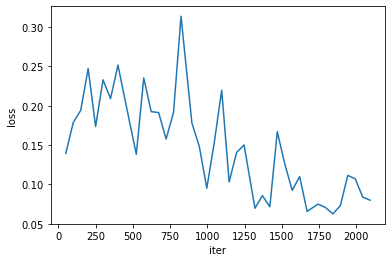

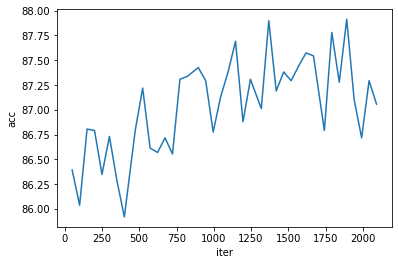

In [25]:
plt.plot(iter_list,loss_list)
plt.xlabel("iter")
plt.ylabel("loss")
plt.show()

plt.plot(iter_list,acc_list)
plt.xlabel("iter")
plt.ylabel("acc")
plt.show()

In [28]:
model.eval()

with torch.no_grad():
    x_test=torch.from_numpy(X_test).float()
    output=model(x_test.to(device))
    pred=torch.max(output,1)[1]

In [31]:
submit['label']=pred.cpu()
submit.head()

,id,label
0,11,1
1,15,0
2,17,4
3,21,7
4,22,4


In [32]:
# submit.to_csv('resnet.csv',index=False)